# 1. SETUP

## 1.1 Imports


In [14]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from A2C_discrete import A2C
from tqdm import tqdm
import os
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1.2 PARAMETERS SETUP


In [15]:
# HYPERPARAMETERS
# environment hyperparams
n_steps = 200000
n_envs = 1
n_steps_per_update = 1
n_updates = n_steps // (n_steps_per_update*n_envs)
evaluation_interval = 10000 # evaluate the agent every 20k steps
n_eval_runs = 10 # how many evaluation runs to do each 20k steps 

# agent hyperparams
gamma = 0.99  # discount factor
ent_coef = 0.01  # coefficient for the entropy bonus (to encourage exploration)
actor_lr = 1e-5
critic_lr = 1e-3
stochasticity_bool = True
stochastic_reward_probability = 0.9
# Note: the actor has a slower learning rate so that the value targets become
# more stationary and are theirfore easier to estimate for the critic

# SEED
def set_seed(seed):
    torch.manual_seed(seed) # pytorch random seed
    np.random.seed(seed) # numpy random seed
# Set a seed value
seed_value = 50
set_seed(seed_value)

# ENVIRONMENT
env = gym.make("CartPole-v1")
env_eval = gym.make("CartPole-v1")
obs_shape = env.observation_space.shape[0]
action_shape = env.action_space.n

# DEVICE
use_cuda = False
if use_cuda:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")


# AGENT
agent = A2C(obs_shape, action_shape, device, critic_lr, actor_lr, n_envs)

# 2. AGENT TRAINING

In [16]:
# LOGGED VARIABLES
critic_losses = []
actor_losses = []
entropies = []
episode_returns = []
steps_episodes = [] # logs the steps taken in each episode
evaluation_returns = [] # logs the returns of the agent during evaluation

# COUNTERS
steps = 0
ep_counter = 0
ep_reward = 0

# VARIABLE INITIALIZATION
is_truncated = False
is_terminated = False
states, info = env.reset(seed=seed_value) #only use the seed when resetting the first time


# use tqdm to get a progress bar for training
for steps in tqdm(range(n_updates+1)):
        

    # reset lists that collect experiences of a n_steps_per_update
    n_value_preds = torch.zeros(n_steps_per_update, n_envs, device=device)
    n_action_log_probs = torch.zeros(n_steps_per_update, n_envs, device=device)
    # don't take mask and reward gradient
    masks = torch.ones(n_steps_per_update, n_envs, device=device,requires_grad = False)
    n_rewards = torch.zeros(n_steps_per_update, n_envs, device=device,requires_grad = False)
    end_states = []
    end_states_idx = [0]

    # play n_steps_per_update to collect data
    for step in range(n_steps_per_update):
        # select an action A_{t} using S_{t} as input for the agent, get actions and values Vt
        actions, action_log_probs, V_t, entropy = agent.select_action(states, bool_greedy=False)

        # ensure no grad is taken in the step
        with torch.no_grad():
            # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
            states, reward, is_terminated, is_truncated, infos = env.step(
                actions.cpu().numpy()
            )
        if stochasticity_bool:
            # introduce stochasticity in the reward
            if np.random.rand() < stochastic_reward_probability:
                reward = 0

        ep_reward += reward # increase episode return
        mask = not is_terminated # define mask for bootstrapping

        # log the value, reward and action log prob of the last step
        n_value_preds[step] = torch.squeeze(V_t)
        n_rewards[step] = torch.tensor(reward, device=device)
        n_action_log_probs[step] = action_log_probs

        # for each env the mask is 1 if the episode is ongoing and 0 if it is terminated (not by truncation!)
        masks[step] = torch.tensor(mask) # allows for correct bootstrapping
        
    # reset environment if truncated or terminated
    if is_terminated or is_truncated:
        states_tensor = torch.tensor(states, device=device) # Transform the last state reached (S_t+n) to a tensor
        end_states.append(states_tensor)
        end_states_idx.append(step)
        states, info = env.reset() # do not use the seed when resetting again
        ep_counter += 1
        steps_episodes.append(steps)
        episode_returns.append(ep_reward)
        ep_reward = 0

    
    # if statement to make sure we don't append the end state twice
    if not is_terminated and not is_truncated:
        states_tensor = torch.tensor(states, device=device) # Transform the last state reached (S_t+n) to a tensor
        end_states.append(states_tensor)
        end_states_idx.append(step)
    # calculate the losses for actor and critic
    critic_loss, actor_loss = agent.get_losses(
        n_rewards,
        n_action_log_probs,
        n_value_preds,
        entropy,
        masks,
        gamma,
        end_states,
        end_states_idx
    )

    # update the actor and critic networks
    agent.update_parameters(critic_loss, actor_loss)

    # log the losses and entropy
    critic_losses.append(critic_loss.detach().cpu().numpy())
    actor_losses.append(actor_loss.detach().cpu().numpy())
    entropies.append(entropy.detach().mean().cpu().numpy())

    #After every 20k steps, evaluate the performance of your agent by running it for 10 episodes with a greedy action policy (without noise)
    #on a newly initialized environment and plotting the evaluation statistics below.
    with torch.no_grad(): # No need to store gradients in the evaluation
        if steps % evaluation_interval == 0 and steps != 0:
            print("EVALUATION")
            # evaluate
            returns = []
            episode_lengths = []
            for i in range(n_eval_runs):
                # Only use the seed when resetting at the beginning to ensure the states will follow the same initialization at every evalutaion step
                if i == 0:
                    state, info = env_eval.reset(seed = seed_value)
                else:
                    state, info = env_eval.reset()
                episode_return = 0
                episode_length = 0
                while True:
                    action, _, _, _ = agent.select_action(state,bool_greedy=True)
                    state, reward, terminated, truncated, info = env_eval.step(action.cpu().numpy())
                    episode_return += reward
                    episode_length += 1
                    if terminated or truncated:
                        break
                returns.append(episode_return)
                episode_lengths.append(episode_length)  
            print(returns)
            evaluation_returns.append(np.mean(returns))





  0%|          | 0/200001 [00:00<?, ?it/s]/opt/anaconda3/envs/rl_project/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  5%|▍         | 9992/200001 [00:40<12:36, 251.28it/s]

EVALUATION


  5%|▌         | 10037/200001 [00:41<40:25, 78.33it/s]

[205.0, 138.0, 138.0, 122.0, 137.0, 188.0, 304.0, 167.0, 296.0, 307.0]


 10%|▉         | 19990/200001 [01:27<11:35, 258.93it/s]

EVALUATION


 10%|█         | 20044/200001 [01:29<35:26, 84.64it/s] 

[225.0, 192.0, 139.0, 215.0, 193.0, 157.0, 323.0, 148.0, 155.0, 443.0]


 15%|█▍        | 29990/200001 [02:16<13:00, 217.91it/s]

EVALUATION


 15%|█▌        | 30039/200001 [02:17<50:49, 55.73it/s]  

[475.0, 208.0, 222.0, 263.0, 242.0, 275.0, 500.0, 251.0, 500.0, 500.0]


 20%|█▉        | 39997/200001 [03:02<08:57, 297.85it/s]

EVALUATION


 20%|██        | 40027/200001 [03:03<49:29, 53.88it/s] 

[455.0, 500.0, 270.0, 373.0, 394.0, 318.0, 360.0, 266.0, 276.0, 500.0]


 25%|██▍       | 49981/200001 [03:38<08:08, 307.37it/s]

EVALUATION


 25%|██▌       | 50040/200001 [03:40<42:12, 59.22it/s] 

[500.0, 500.0, 366.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]


 30%|██▉       | 59971/200001 [04:19<07:34, 308.38it/s]

EVALUATION


 30%|███       | 60033/200001 [04:21<35:33, 65.59it/s] 

[500.0, 500.0, 324.0, 500.0, 500.0, 388.0, 458.0, 306.0, 397.0, 500.0]


 35%|███▍      | 69981/200001 [04:55<09:24, 230.34it/s]

EVALUATION


 35%|███▌      | 70027/200001 [04:58<55:25, 39.09it/s]  

[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]


 40%|███▉      | 79988/200001 [05:39<08:15, 242.13it/s]

EVALUATION


 40%|████      | 80035/200001 [05:41<44:26, 45.00it/s] 

[406.0, 347.0, 500.0, 500.0, 391.0, 500.0, 419.0, 500.0, 435.0, 500.0]


 45%|████▍     | 89981/200001 [06:21<07:01, 261.26it/s]

EVALUATION


 45%|████▌     | 90031/200001 [06:24<40:59, 44.71it/s] 

[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]


 50%|████▉     | 99989/200001 [07:03<06:26, 258.56it/s]

EVALUATION


 50%|█████     | 100035/200001 [07:06<41:24, 40.24it/s]

[500.0, 500.0, 500.0, 500.0, 417.0, 500.0, 500.0, 500.0, 500.0, 500.0]


 55%|█████▍    | 109994/200001 [07:45<05:53, 254.79it/s]

EVALUATION


 55%|█████▌    | 110039/200001 [07:49<46:14, 32.43it/s] 

[500.0, 444.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]


 60%|█████▉    | 119984/200001 [08:29<05:23, 247.24it/s]

EVALUATION


 60%|██████    | 120030/200001 [08:31<34:03, 39.14it/s] 

[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]


 65%|██████▍   | 129985/200001 [09:12<03:52, 300.63it/s]

EVALUATION


 65%|██████▌   | 130016/200001 [09:15<36:24, 32.04it/s] 

[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]


 70%|██████▉   | 139988/200001 [09:57<03:56, 254.19it/s]

EVALUATION


 70%|███████   | 140045/200001 [09:59<18:47, 53.17it/s] 

[445.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]


 75%|███████▍  | 149985/200001 [10:38<04:28, 186.19it/s]

EVALUATION


 75%|███████▌  | 150004/200001 [10:41<43:31, 19.15it/s] 

[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]


 80%|███████▉  | 159991/200001 [11:25<02:25, 275.88it/s]

EVALUATION


 80%|████████  | 160046/200001 [11:28<14:26, 46.08it/s] 

[500.0, 419.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]


 85%|████████▍ | 169976/200001 [12:11<01:58, 254.09it/s]

EVALUATION


 85%|████████▌ | 170002/200001 [12:13<15:24, 32.44it/s] 

[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]


 90%|████████▉ | 179975/200001 [12:53<01:18, 256.29it/s]

EVALUATION


 90%|█████████ | 180023/200001 [12:56<07:25, 44.83it/s] 

[500.0, 500.0, 414.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]


 95%|█████████▍| 189981/200001 [13:36<00:39, 254.57it/s]

EVALUATION


 95%|█████████▌| 190031/200001 [13:38<03:43, 44.66it/s] 

[455.0, 500.0, 432.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]


100%|█████████▉| 199978/200001 [14:18<00:00, 232.84it/s]

EVALUATION


100%|██████████| 200001/200001 [14:20<00:00, 232.30it/s]

[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]


# 3. RESULTS

## 3.1 PLOTTING

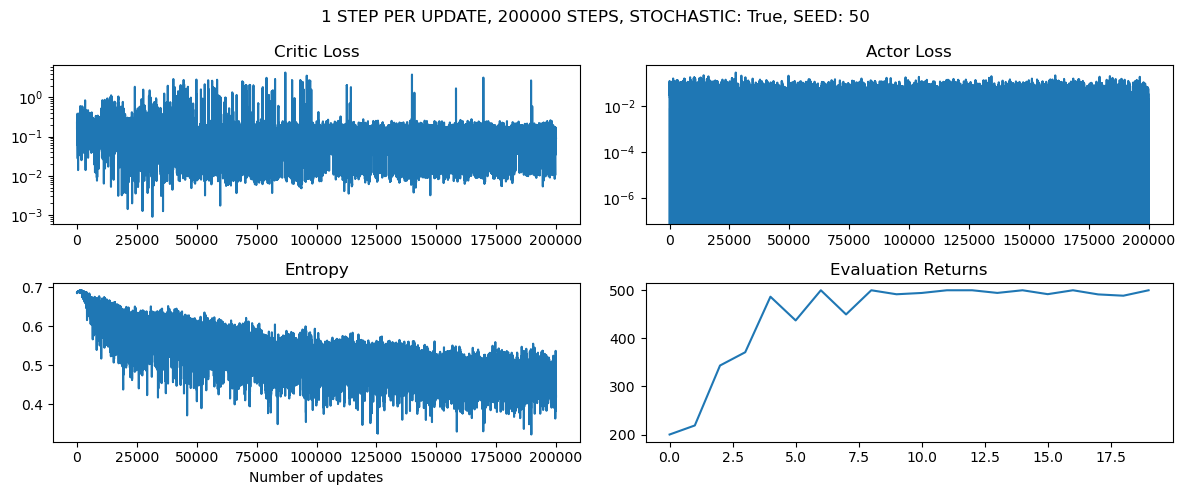

In [17]:
rolling_length = 30

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 5))
#set title of the plot
fig.suptitle(f"{n_steps_per_update} STEP PER UPDATE, {n_steps} STEPS, STOCHASTIC: {stochasticity_bool}, SEED: {seed_value}")
critic_losses = np.array(critic_losses)
capped_loss = critic_losses[critic_losses < 1]
critic_ma = (
    np.convolve(np.array(critic_losses), np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[0, 0].plot(critic_ma)
axs[0, 0].set_title('Critic Loss')
axs[0, 0].set_yscale('log')  # Set log scale for the y-axis
actor_ma = (
    np.convolve(np.array(actor_losses), np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[0, 1].plot(actor_ma)
axs[0, 1].set_title('Actor Loss')
axs[0, 1].set_yscale('log')  # Set log scale for the y-axis


# entropy
axs[1][0].set_title("Entropy")
entropy_moving_average = (
    np.convolve(np.array(entropies), np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[1][0].plot(entropy_moving_average)
axs[1][0].set_xlabel("Number of updates")



#axs[1, 1].plot(steps_episodes, episode_returns)
#axs[1, 1].set_title('Episode Rewards')
axs[1, 1].plot(evaluation_returns)
axs[1, 1].set_title('Evaluation Returns')
plt.tight_layout()
plt.show()


## 3.2 SAVE PLOTS

In [20]:
#save the plot
if stochasticity_bool:
    fig.savefig(f"figures/A2C_{n_steps_per_update}step_stoch_seed{seed_value}.png")
else:
    fig.savefig(f"figures/A2C_{n_steps_per_update}step_nostoch_seed{seed_value}.png")

In [ ]:
plt.plot(evaluation_returns)
plt.title("Evaluation returns")
plt.xlabel("Number of evaluations")
plt.ylabel("Return")
plt.show()

## 3.3 SAVE/LOAD AGENT WEIGHTS

In [9]:
save_weights = True
load_weights = False

actor_weights_path = "weights/actor_weightss.h5"
critic_weights_path = "weights/critic_weightss.h5"

if not os.path.exists("weights"):
    os.mkdir("weights")

""" save network weights """
if save_weights:
    torch.save(agent.actor.state_dict(), actor_weights_path)
    torch.save(agent.critic.state_dict(), critic_weights_path)


""" load network weights """
if load_weights:
    agent = A2C(obs_shape, action_shape, device, critic_lr, actor_lr, 1)

    agent.actor.load_state_dict(torch.load(actor_weights_path))
    agent.critic.load_state_dict(torch.load(critic_weights_path))
    agent.actor.eval()
    agent.critic.eval()

## 3.4 SHOWCASE AGENT

In [10]:
n_showcase_episodes = 3

for episode in range(n_showcase_episodes):
    print(f"starting episode {episode}...")

    # create a new sample environment to get new random parameters
    env = gym.make("CartPole-v1", render_mode="human", max_episode_steps=500)

    # get an initial state
    state, info = env.reset()

    # play one episode
    done = False
    while not done:
        # select an action A_{t} using S_{t} as input for the agent
        with torch.no_grad():
            action, _, _, _ = agent.select_action(state[None, :], bool_greedy=True)

        # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
        state, reward, terminated, truncated, info = env.step(action.item())

        # update if the environment is done
        done = terminated or truncated

env.close()

starting episode 0...


/opt/anaconda3/envs/rl_project/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


starting episode 1...
starting episode 2...


: 